In [25]:
import numpy as np
np.random.seed(0)
IMG_WIDTH=150
IMG_HEIGHT=150
from keras.applications.vgg16 import VGG16
from keras.models import Model
import keras
restnet = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

/home/ravi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  # This is added back by InteractiveShellApp.init_path()


In [26]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
input_shape=(IMG_HEIGHT,IMG_WIDTH,3)
model = Sequential()
model.add(restnet)
model.add(Dense(256, activation='relu', input_dim=input_shape))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_10 (Model)             (None, 8192)              14714688  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size = 100
epochs = 100

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

model.compile(loss='binary_crossentropy',
#               optimizer="adam"
              optimizer = optimizers.adam(lr=1e-4)
              ,
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')

# fine-tune the model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=4999 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps= 1000 // batch_size,
#         callbacks=[early_stopping]
        )

Found 3998 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/100
49/49 [==============================] - 511s 10s/step - loss: 0.4206 - accuracy: 0.8299 - val_loss: 0.3432 - val_accuracy: 0.8780
Epoch 2/100
49/49 [==============================] - 530s 11s/step - loss: 0.3560 - accuracy: 0.8657 - val_loss: 0.3062 - val_accuracy: 0.9030
Epoch 3/100
49/49 [==============================] - 530s 11s/step - loss: 0.3499 - accuracy: 0.8601 - val_loss: 0.4048 - val_accuracy: 0.8820
Epoch 4/100
49/49 [==============================] - 536s 11s/step - loss: 0.3392 - accuracy: 0.8666 - val_loss: 0.4095 - val_accuracy: 0.8780
Epoch 5/100
49/49 [==============================] - 533s 11s/step - loss: 0.3247 - accuracy: 0.8744 - val_loss: 0.3029 - val_accuracy: 0.8880
Epoch 6/100
49/49 [==============================] - 531s 11s/step - loss: 0.3173 - accuracy: 0.8770 - val_loss: 0.4023 - val_accuracy: 0.9040
Epoch 7/100
49/49 [==============================] - 531s 1

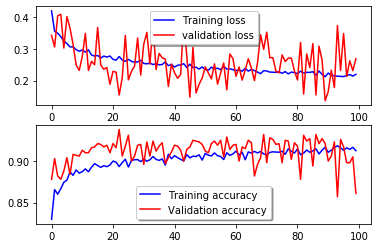

In [38]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [39]:
scores1 = model.evaluate(train_generator, verbose=0)

In [40]:
print ('Test loss:', scores1[0]*100)
print ('Test accuracy:', scores1[1]*100)

Test loss: 21.359026432037354
Test accuracy: 90.9704864025116


In [49]:
scores = model.evaluate(validation_generator, verbose=0)

In [50]:
print ('Validation loss:', scores[0]*100)
print ('Validation accuracy:', scores[1]*100)

Validation loss: 30.717751383781433
Validation accuracy: 86.12499833106995


In [51]:
model.save("models/vacc8612-vlss3071-tacc9097-tlss2135.h5")
print("Saved model to disk")

Saved model to disk
